In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import io
from yass.augment import make
from pathlib import Path

import yass
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage
from yass import set_config, read_config
from yass.templates import TemplatesProcessor
from yass.neuralnetwork.evaluate import Dataset
from yass.neuralnetwork import evaluate

import seaborn as sns
import pandas as pd
from dstools import plot

In [3]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

In [4]:
path_to_ground_truth = str(Path('~/data/groundtruth_ej49_data1_set1.mat').expanduser())

kk = io.loadmat(path_to_ground_truth)

# L_gt has length total number of spikes; it is the cluster index for each spike
# spt_gt has length total number of spikes; it is the time for each spike
L_gt = kk['L_gt']-1
spt_gt = kk['spt_gt'] + 10
spike_train = np.concatenate((spt_gt, L_gt),axis=1)

min_amp = 5
max_amp = 80
n_clean_per_template = 20


path_to_standarized = str(Path('~/data/tmp/preprocess/standarized.bin').expanduser())

chosen_templates = [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13,
                    14, 15, 16, 17, 18, 19, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                    36, 37, 38, 39, 41, 42, 43, 44, 45, 46,
                    47, 48]

n_templates = np.max(spike_train[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [5]:
processor = TemplatesProcessor.from_spike_train(CONFIG,
                                                4 * CONFIG.spike_size,
                                                spike_train, path_to_standarized)

100%|██████████| 3/3 [00:22<00:00,  7.60s/it]


In [6]:
aligned = processor.align(CONFIG.spike_size)

In [7]:
cropped = processor.crop_spatially(CONFIG.neigh_channels, CONFIG.geom)

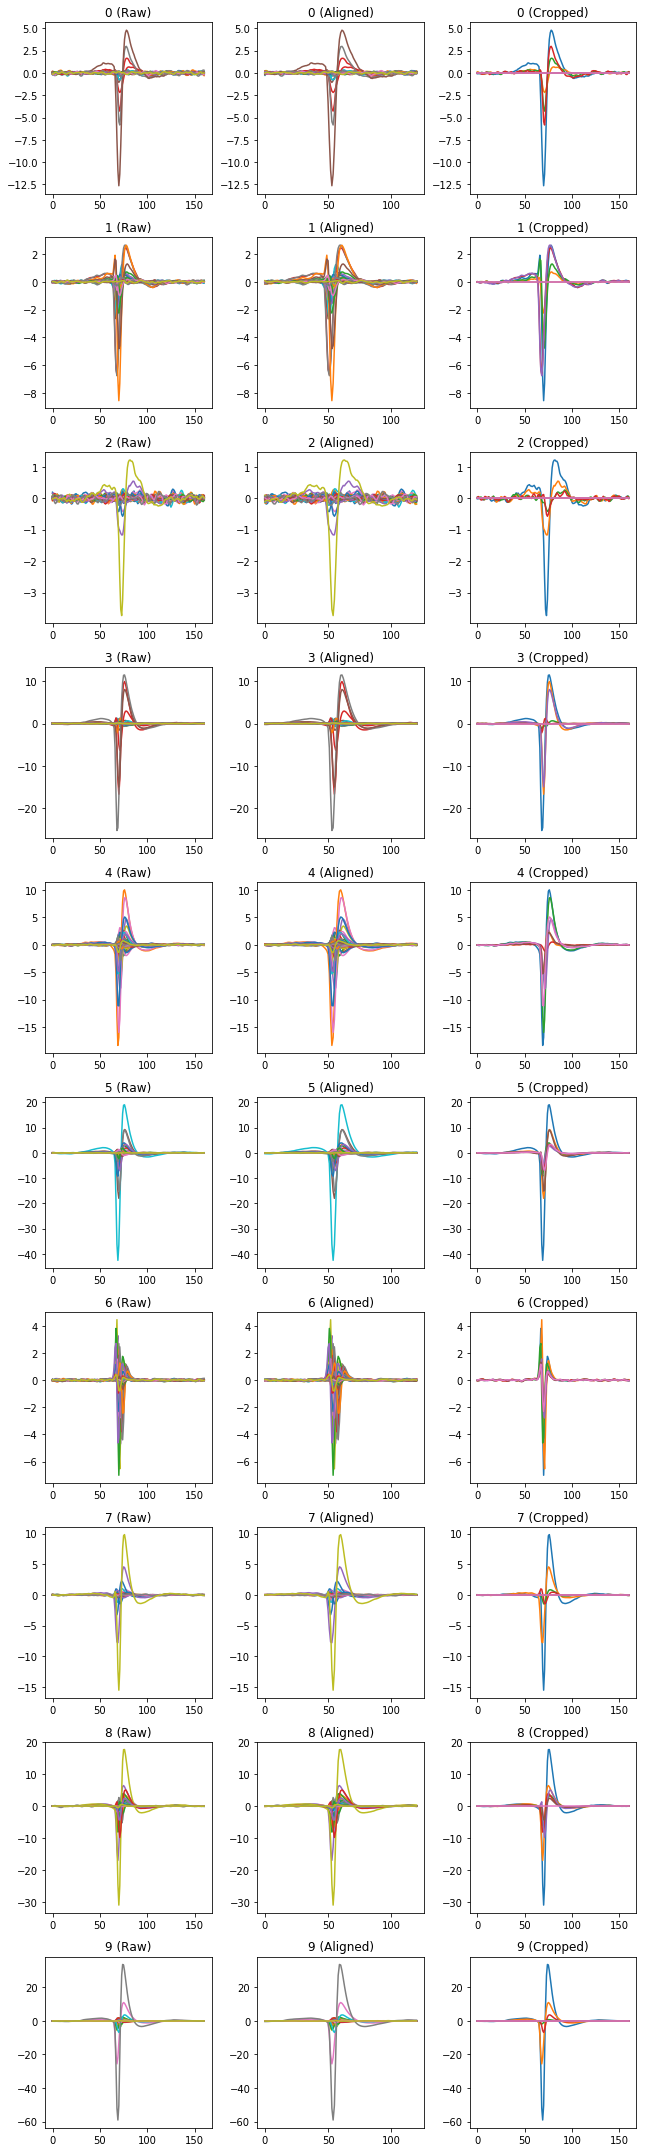

In [8]:
plot.grid_from_array([processor.values,
                      aligned.values, cropped.values],
                     axis=0,
                     elements=range(10),
                     auto_figsize=3,
                     group_names=('Raw', 'Aligned', 'Cropped'))

In [9]:
small = cropped.crop_temporally(20)
small.values.shape

(49, 41, 7)

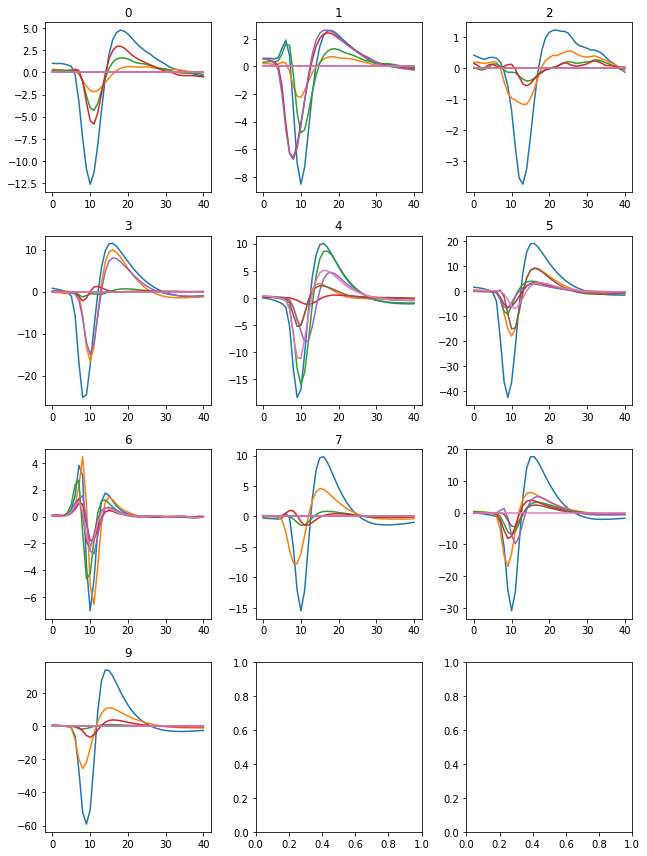

In [10]:
plot.grid_from_array(small.values,
                     axis=0,
                     elements=range(10),
                     auto_figsize=3)

In [11]:
dataset = Dataset(2, small.values,
                  min_amp, max_amp,
                  path_to_standarized,
                  n_clean_per_template,
                  CONFIG.geom,
                  make_spatially_misaligned=True,
                  make_temporally_misaligned=True,
                  make_collided=True,
                  make_zero_signal=True)

In [12]:
dataset.stats

{'from templates': 980,
 'spatially misaligned': 980,
 'temporally misaligned': 980,
 'collided': 980,
 'zero': 980}

In [13]:
dataset.df_noisy.head()

,waveform,amplitude,kind,amplitude_group
0,"[[0.490244802696373, 0.18397530844140533, -1.8...",5.00,from templates,5.00
1,"[[0.5405981268559921, -0.3377322295745347, 0.5...",8.75,from templates,8.75
2,"[[1.5689718409858617, 2.8314959851960984, 2.22...",12.50,from templates,12.50
3,"[[0.7620004265052502, 1.4951007354524786, 1.60...",16.25,from templates,16.25
4,"[[2.651509481836358, 0.19392259382763727, 0.41...",20.00,from templates,20.00


## Predict on patches

In [42]:
path_to_model = '/home/Edu/dev/private-yass/nnet/models/detect/26-Jul-2018@22-38-25.ckpt'
model = NeuralNetDetector.load(path_to_model, 0.5, CONFIG.channel_index)

In [43]:
preds = ['{:.2f}'.format(p) for p in model.predict_proba(small.values)]

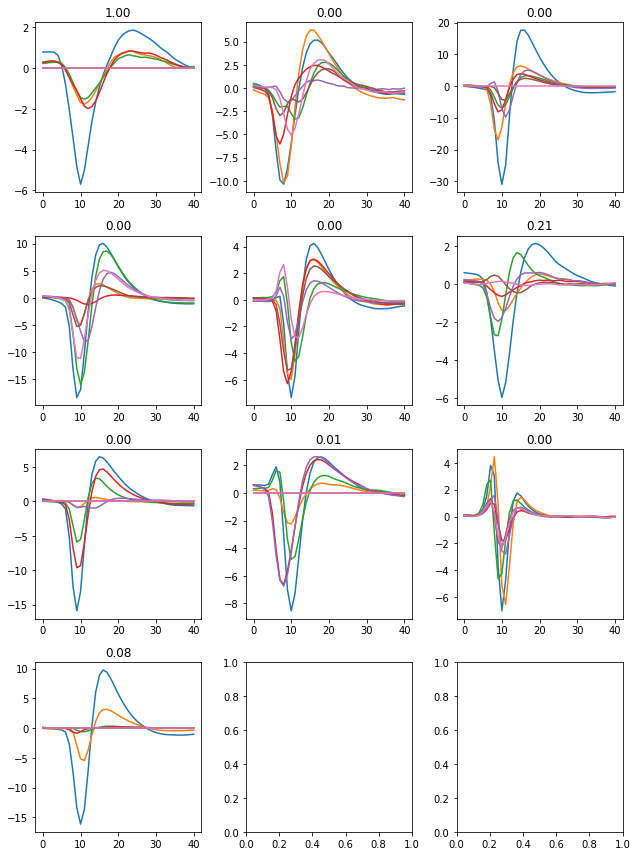

In [44]:
plot.grid_from_array(small.values,
                     axis=0,
                     elements=10,
                     auto_figsize=3,
                     labels=preds)

In [48]:
all_channels = aligned.crop_temporally(20)

model.predict_recording(all_channels.values[0])

[array([], shape=(0, 2), dtype=int32)]

In [84]:
def shifter_generator(x, waveform_length, step):
    original_wf_length, n_channels = x.shape    
    n = int((original_wf_length - waveform_length)/step + 1)

    shifted = np.zeros((n, waveform_length, n_channels))
    
    for i in range(n):
        shifted[i, :, :] = x[(i * step):waveform_length + (i * step), :]
    
    return shifted

def predict_plot(model, x):
    preds = ['{:.2f}'.format(p) for p in model.predict_proba(x)]

    plot.grid_from_array(x,
                         axis=0,
                         auto_figsize=3,
                         labels=preds)


def shift_predict_plot(x, waveform_length, step, model):
    shifted = shifter_generator(x, waveform_length, step)
    predict_plot(model, shifted)

In [88]:
cropped.values[0].shape

(161, 7)

In [91]:
# shifted = shifter_generator(cropped.values[0], 41, step=4)

names = ('spike_index', 'probability', 'waveform')
spike_index, prob, wave = model.predict_recording(cropped.values[0],
                                                  output_names=names)

In [101]:
spike_index.shape, prob.shape, wave.shape

((8, 2), (161, 49), (8, 41, 19))

In [92]:
spike_index

array([[76,  4],
       [76,  5],
       [77,  0],
       [77,  1],
       [77,  2],
       [77,  3],
       [77, 11],
       [77, 15]], dtype=int32)

In [95]:
cropped.values[0].shape

(161, 7)

In [94]:
prob.shape

(161, 49)

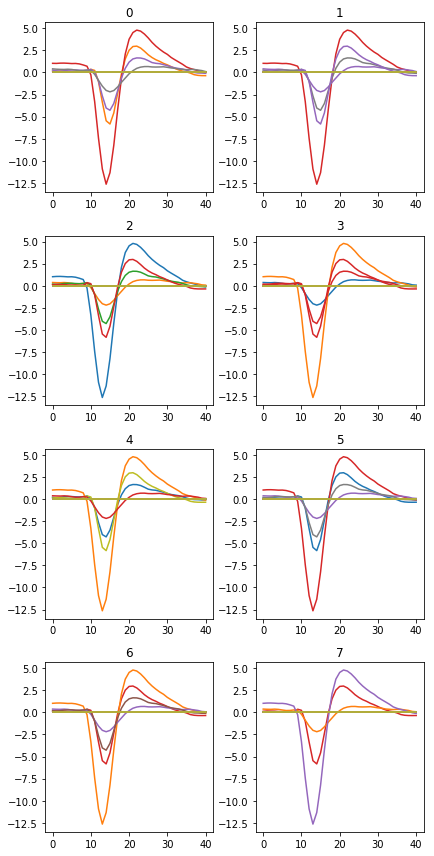

In [99]:
plot.grid_from_array(wave, axis=0, auto_figsize=3)

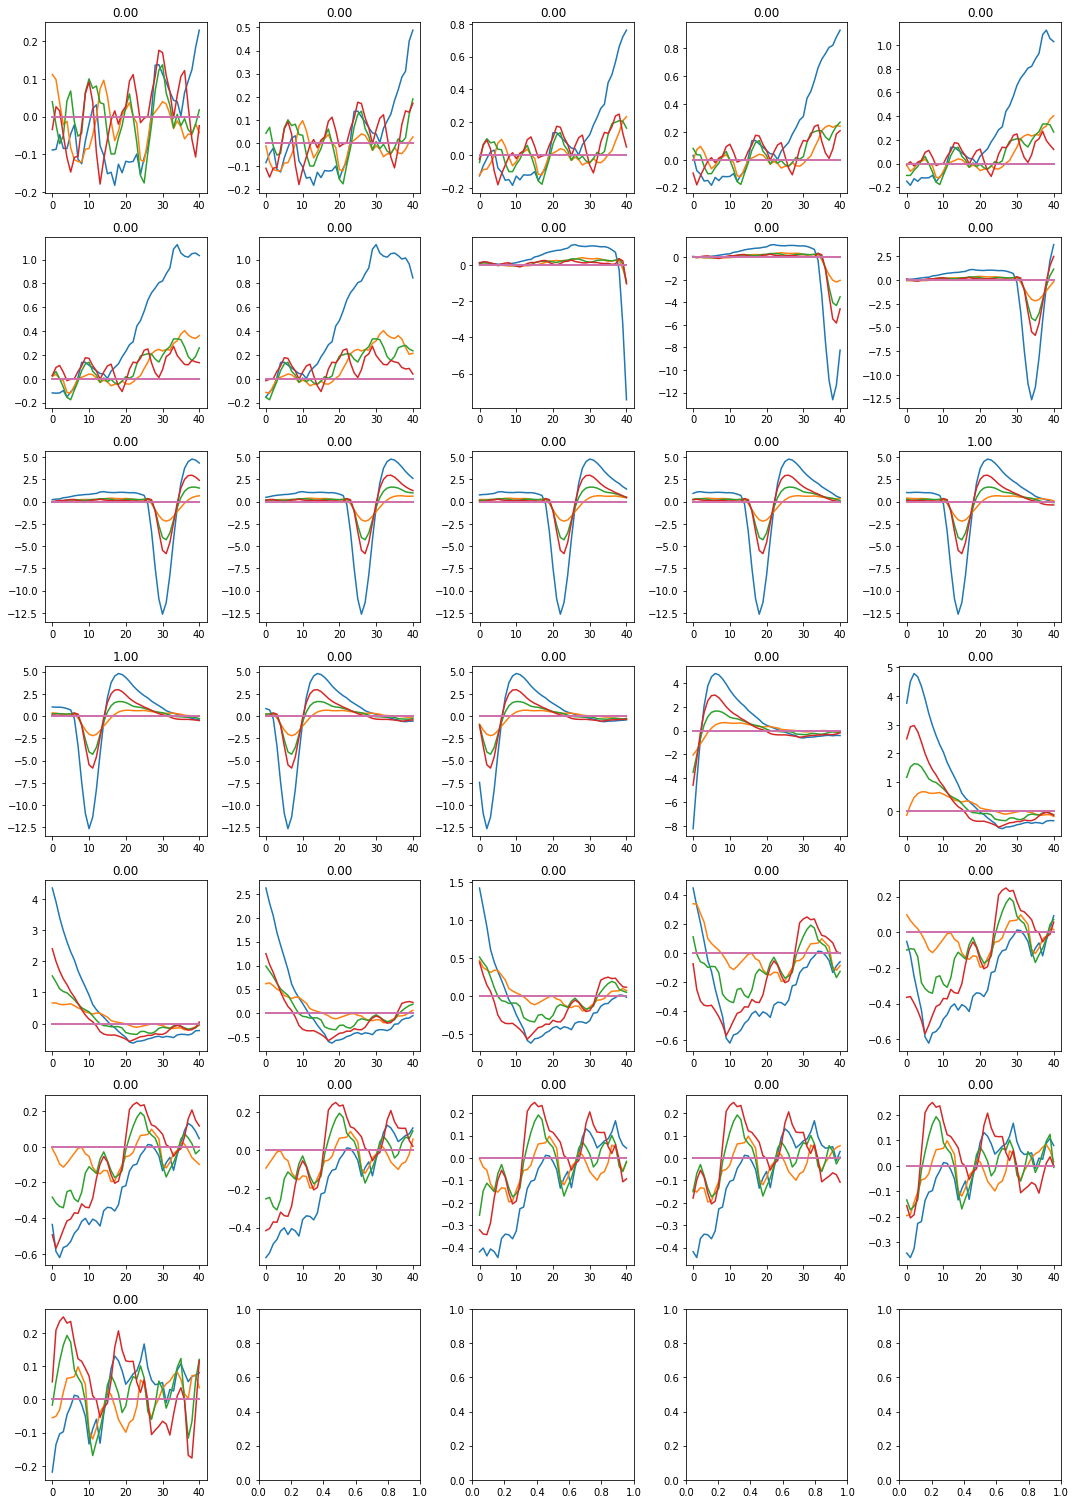

In [86]:
shift_predict_plot(cropped.values[0], 41, step=4, model=model)

## Predict on recordings

## Performance for increasing SNR spikes

In [ ]:
def process_group(g_id, g, model):
    wfs = np.stack(g.waveform.values, axis=0)
    preds = model.predict(wfs)
    return g_id, (preds == 0).mean()

def compute_proportions(df, model):
    # group and compute proportion of correct predictions
    vals = [process_group(g_id, g, model) for g_id, g
            in df.groupby('amplitude_group')]
    amplitudes, props = list(zip(*vals))

    return amplitudes, props

In [117]:
# '/home/Edu/dev/private-yass/nnet/models/detect-11-Jul-2018@21-00-57.ckpt'
# '/home/Edu/shengao-models/detect_nn_min3max15_noise2.ckpt'

m = '/home/Edu/dev/private-yass/nnet/models/detect/26-Jul-2018@22-38-25.ckpt'
m = '/home/Edu/dev/private-yass/nnet/models/triage/26-Jul-2018@22-39-16.ckpt'

paths = [m]

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 10 Text xticklabel objects>)

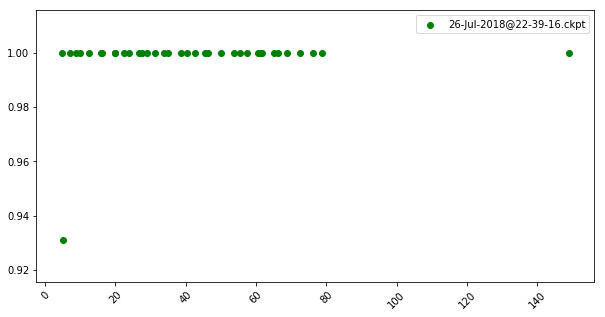

In [118]:
plt.rcParams['figure.figsize'] = (10, 5)

colors = ['g', 'r', 'b', 'k']

df = dataset.df_noisy
df = df[df.kind.isin(('collided', ))]

# make plots for every model
for i, path_to_model in enumerate(paths):

    # load model
#     model = NeuralNetDetector.load(path_to_model, 0.5, CONFIG.channel_index)
    model = NeuralNetTriage.load(path_to_model, 0.5)
    
    # pass spikes and make predictions
    amps, props = compute_proportions(df, model)
    
    # plot results
    plt.scatter(amps, props, color=colors[i],
                label=path_to_model.split('/')[-1])

plt.legend()
plt.xticks(rotation=45)